In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt


/Users/mvin/Code/Urbanomy/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
['residential', 'recreation', 'special', 'industrial', 'agriculture', 'transport', 'business', 'basic', 'residential_individual', 'residential_lowrise', 'residential_midrise', 'residential_multistorey', 'unknown', 'mixed_use']


['residential',
 'recreation',
 'special',
 'industrial',
 'agriculture',
 'transport',
 'business',
 'basic',
 'residential_individual',
 'residential_lowrise',
 'residential_midrise',
 'residential_multistorey',
 'unknown',
 'mixed_use']

In [3]:
territory_gdf = gpd.read_file('data/level_4_territories.geojson').to_crs(32636)

In [4]:
territory_gdf

,territory_id,territory_type,parent,name,level,properties,admin_center,target_city_type,okato_code,oktmo_code,is_city,created_at,updated_at,geometry
0,3,"{ ""id"": 3, ""name"": ""Поселение"" }","{ ""id"": 2, ""name"": ""Бокситогорский муниципальн...",Самойловское сельское поселение,4,"{ ""Численность населения"": 2154, ""Администрати...","{ ""id"": 310, ""name"": ""поселок Совхозный"" }",None,41203876000,41603476,False,2024-06-16 21:35:40.802000+00:00,2024-11-14 12:17:52.704000+00:00,"POLYGON ((580049.515 6617067.72, 580225.344 66..."
1,4,"{ ""id"": 3, ""name"": ""Поселение"" }","{ ""id"": 2, ""name"": ""Бокситогорский муниципальн...",Большедворское сельское поселение,4,"{ ""Численность населения"": 1698, ""Администрати...","{ ""id"": 427, ""name"": ""деревня Большой Двор"" }",None,41203812000,41603412,False,2024-06-16 21:35:40.802000+00:00,2024-11-14 12:17:34.396000+00:00,"POLYGON ((573514.444 6620389.851, 573579.919 6..."
2,5,"{ ""id"": 3, ""name"": ""Поселение"" }","{ ""id"": 2, ""name"": ""Бокситогорский муниципальн...",Пикалевское городское поселение,4,"{ ""Численность населения"": 20169, ""Администрат...","{ ""id"": 335, ""name"": ""город Пикалево"" }",None,41440000000,41603102,False,2024-06-16 21:35:40.802000+00:00,2024-11-14 12:17:34.930000+00:00,"POLYGON ((564707.328 6594903.594, 564341.814 6..."
3,6,"{ ""id"": 3, ""name"": ""Поселение"" }","{ ""id"": 2, ""name"": ""Бокситогорский муниципальн...",Борское сельское поселение,4,"{ ""Численность населения"": 3393, ""Администрати...","{ ""id"": 2859, ""name"": ""деревня Бор"" }",None,41203816000,41603416,False,2024-06-16 21:35:40.802000+00:00,2024-11-14 12:17:35.368000+00:00,"POLYGON ((560629.509 6557332.762, 560642.857 6..."
4,7,"{ ""id"": 3, ""name"": ""Поселение"" }","{ ""id"": 2, ""name"": ""Бокситогорский муниципальн...",Бокситогорское городское поселение,4,"{ ""Численность населения"": 15960, ""Администрат...","{ ""id"": 328, ""name"": ""город Бокситогорск"" }",None,41403000000,41603101,False,2024-06-16 21:35:40.802000+00:00,2024-11-14 12:17:36.351000+00:00,"POLYGON ((560659.317 6585430.874, 559919.213 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,204,"{ ""id"": 3, ""name"": ""Поселение"" }","{ ""id"": 193, ""name"": ""Тосненский муниципальный...",Красноборское городское поселение,4,"{ ""Численность населения"": 4507, ""Администрати...","{ ""id"": 3072, ""name"": ""городской поселок Красн...",None,41248554000,41648154,False,2024-06-16 21:35:40.802000+00:00,2024-11-14 12:19:09.784000+00:00,"POLYGON ((363803.737 6614904.469, 363821.597 6..."
185,205,"{ ""id"": 3, ""name"": ""Поселение"" }","{ ""id"": 193, ""name"": ""Тосненский муниципальный...",Трубникоборское сельское поселение,4,"{ ""Численность населения"": 1620, ""Администрати...","{ ""id"": 3122, ""name"": ""деревня Трубников Бор"" }",None,41248844000,41648444,False,2024-06-16 21:35:40.802000+00:00,2024-11-14 12:19:10.264000+00:00,"POLYGON ((392924.072 6551507.217, 393174.409 6..."
186,206,"{ ""id"": 3, ""name"": ""Поселение"" }","{ ""id"": 193, ""name"": ""Тосненский муниципальный...",Лисинское сельское поселение,4,"{ ""Численность населения"": 1919, ""Администрати...","{ ""id"": 3095, ""name"": ""поселок Лисино-Корпус"" }",None,41248830000,41648430,False,2024-06-16 21:35:40.802000+00:00,2024-11-14 12:19:25.346000+00:00,"POLYGON ((363959.223 6596385.107, 364013.066 6..."
187,1267,"{ ""id"": 4, ""name"": ""Город"" }","{ ""id"": 182, ""name"": ""Сосновоборский городской...",город Сосновый бор,4,{ },None,None,41454000000,41754000001,True,2024-06-16 21:35:40.802000+00:00,2024-11-29 11:31:30.081000+00:00,"POLYGON ((283435.008 6647206.979, 283361.394 6..."


In [5]:
territory_gdf = territory_gdf[['territory_id', 'geometry']]
territory_gdf

,territory_id,geometry
0,3,"POLYGON ((580049.515 6617067.72, 580225.344 66..."
1,4,"POLYGON ((573514.444 6620389.851, 573579.919 6..."
2,5,"POLYGON ((564707.328 6594903.594, 564341.814 6..."
3,6,"POLYGON ((560629.509 6557332.762, 560642.857 6..."
4,7,"POLYGON ((560659.317 6585430.874, 559919.213 6..."
...,...,...
184,204,"POLYGON ((363803.737 6614904.469, 363821.597 6..."
185,205,"POLYGON ((392924.072 6551507.217, 393174.409 6..."
186,206,"POLYGON ((363959.223 6596385.107, 364013.066 6..."
187,1267,"POLYGON ((283435.008 6647206.979, 283361.394 6..."


In [6]:
# 1. Создание и обучение модели
# Инициализация LabelEncoder с известными значениями LandUseType
le = LabelEncoder()
le.fit(['residential', 'recreation', 'special', 'industrial', 
        'agriculture', 'transport', 'business', 'basic', 
        'residential_individual', 'residential_lowrise', 
        'residential_midrise', 'residential_multistorey', 'unknown', 
        'mixed_use'])  # Обучаем на строковых метках

# Генерация данных для обучения модели
np.random.seed(42)
n_samples = 1000
data = {
    'LandUseType': np.random.choice(['residential', 'recreation', 'special', 'industrial', 
                                     'agriculture', 'transport', 'business', 'basic', 
                                     'residential_individual', 'residential_lowrise', 'residential_midrise', 
                                     'residential_multistorey', 'unknown', 'mixed_use'], n_samples),

    'LocationScore': np.random.uniform(1, 10, n_samples),
    'AreaTotal': np.random.uniform(100, 20000, n_samples),
    'AreaResidential': np.random.uniform(0, 15000, n_samples),
    'AreaCommercial': np.random.uniform(0, 10000, n_samples),
    'Infrastructure': np.random.uniform(1, 10, n_samples),
    'RoadDevelopment': np.random.uniform(1, 10, n_samples),
    'EcoRestrictions': np.random.uniform(0, 5, n_samples),
    'PopulationDensity': np.random.uniform(50, 5000, n_samples),
    'AvgIncomeLevel': np.random.uniform(20000, 100000, n_samples),
    'DistanceToCenter': np.random.uniform(0.5, 20, n_samples),
    'MarketDemand': np.random.uniform(1, 10, n_samples),
    'Taxes': np.random.uniform(1000, 5000, n_samples),
    'Income': np.random.uniform(5000, 20000, n_samples),
    'ProvisionLevel': np.random.uniform(1, 10, n_samples)
}

land_use_effect = {
    'residential': 0.7,  # Жилая зона – средняя привлекательность, стабильный спрос
    'recreation': 0.4,  # Рекреационная зона – низкая доходность, но ценно для экологии и туризма
    'special': 0.3,  # Особого назначения – ограниченное использование, низкая инвестиционная привлекательность
    'industrial': 1.2,  # Промышленная зона – стабильный доход, но зависимость от экономики
    'agriculture': 0.5,  # Сельскохозяйственная зона – низкая доходность, но долгосрочные инвестиции
    'transport': 0.8,  # Транспортная зона – средняя привлекательность, но зависимость от инфраструктуры
    'business': 2.0,  # Общественно-деловая зона – высокая инвестиционная привлекательность
    'basic': 0.2,  # Базовая зона – малоперспективная для инвестиций
    'residential_individual': 0.9,  # ИЖС – средняя доходность, зависит от спроса
    'residential_lowrise': 1.0,  # Малоэтажная жилая зона – хороший баланс доходности и стабильности
    'residential_midrise': 1.2,  # Среднеэтажная жилая зона – выше привлекательность, плотность застройки
    'residential_multistorey': 1.5,  # Многоэтажная жилая зона – высокая инвестиционная привлекательность
    'unknown': 0.1,  # Неизвестное назначение – крайне низкая привлекательность
    'mixed_use': 1.8  # Многофункциональная зона – высокая привлекательность за счет гибкости использования
}


# Формула доходности с учетом новых признаков
data['InvestmentReturn'] = (
    0.4 * data['LocationScore'] +
    0.3 * data['Infrastructure'] +
    0.2 * data['RoadDevelopment'] -
    0.2 * data['EcoRestrictions'] +
    0.1 * np.log(data['PopulationDensity']) +
    0.2 * data['AvgIncomeLevel'] / 10000 -
    0.3 * data['DistanceToCenter'] +
    0.3 * data['MarketDemand'] +
    0.3 * (data['AreaTotal'] / 10000) +
    0.2 * (data['AreaResidential'] / 10000) +
    0.4 * (data['AreaCommercial'] / 10000) -
    0.3 * (data['Taxes'] / 1000) +
    0.4 * (data['Income'] / 10000) +
    0.2 * data['ProvisionLevel'] +
    [land_use_effect[land] for land in data['LandUseType']] +
    np.random.normal(0, 0.5, n_samples)
)
df = pd.DataFrame(data)

# Подготовка данных для обучения
df['LandUseType'] = le.transform(df['LandUseType'])  # Кодируем строковые метки в числовые
X = df.drop('InvestmentReturn', axis=1)
y = df['InvestmentReturn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, alpha=1.0, random_state=42)
model.fit(X_train, y_train)

# Оценка
print(f"Точность на обучающей выборке (R²): {model.score(X_train, y_train):.3f}")
print(f"Точность на тестовой выборке (R²): {model.score(X_test, y_test):.3f}")



Точность на обучающей выборке (R²): 0.904
Точность на тестовой выборке (R²): 0.815


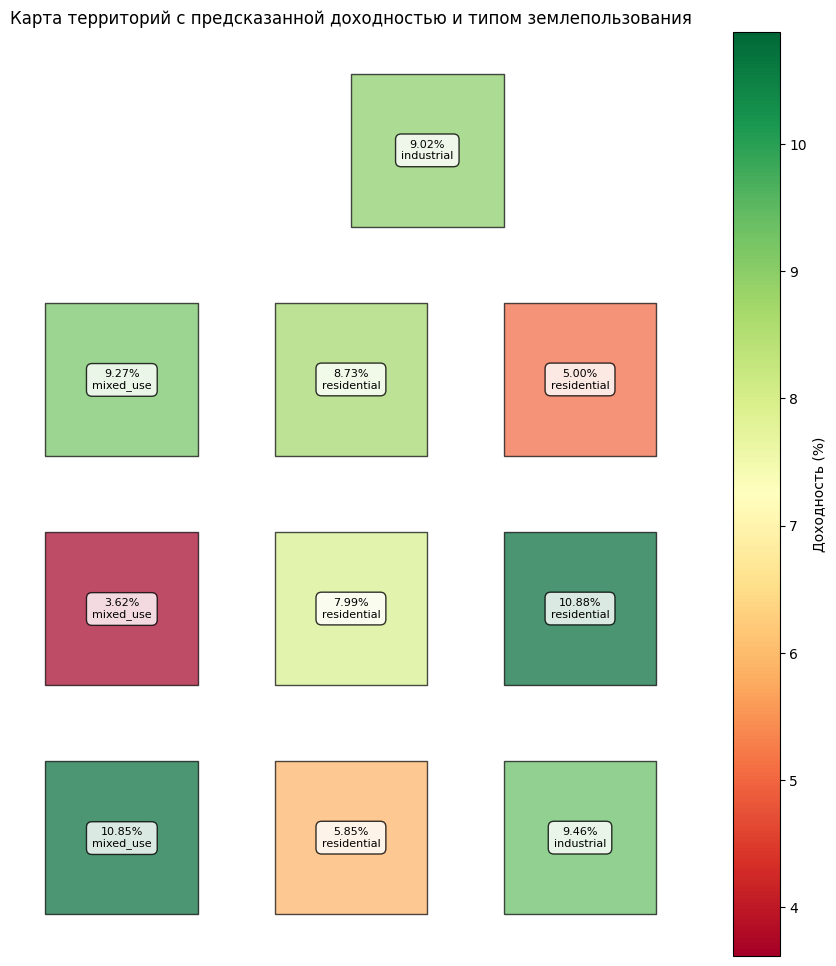

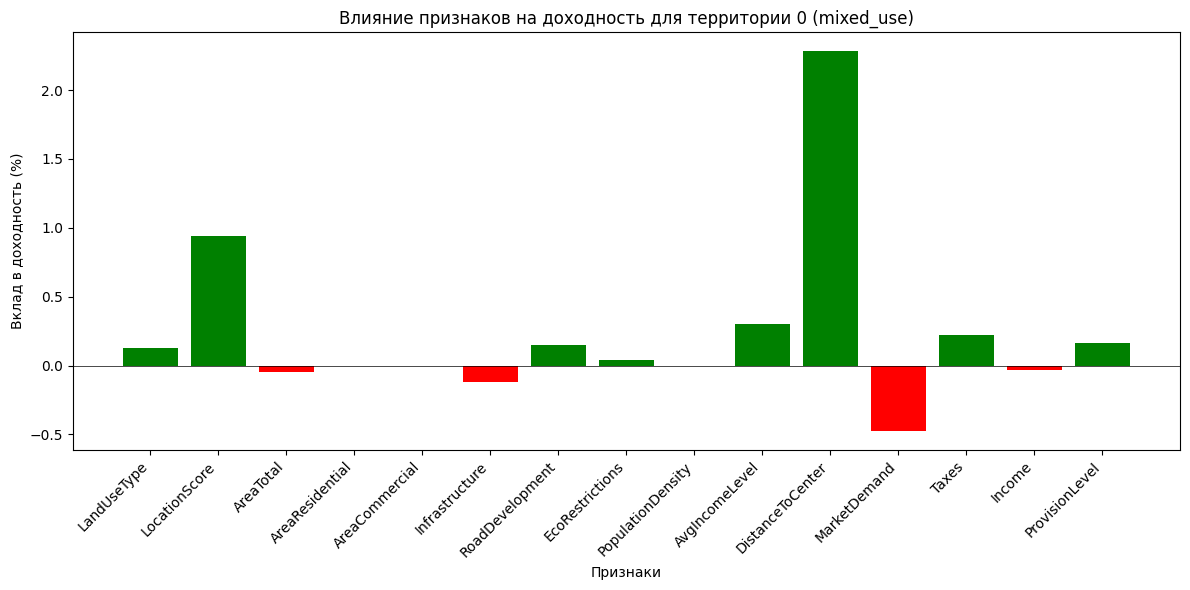

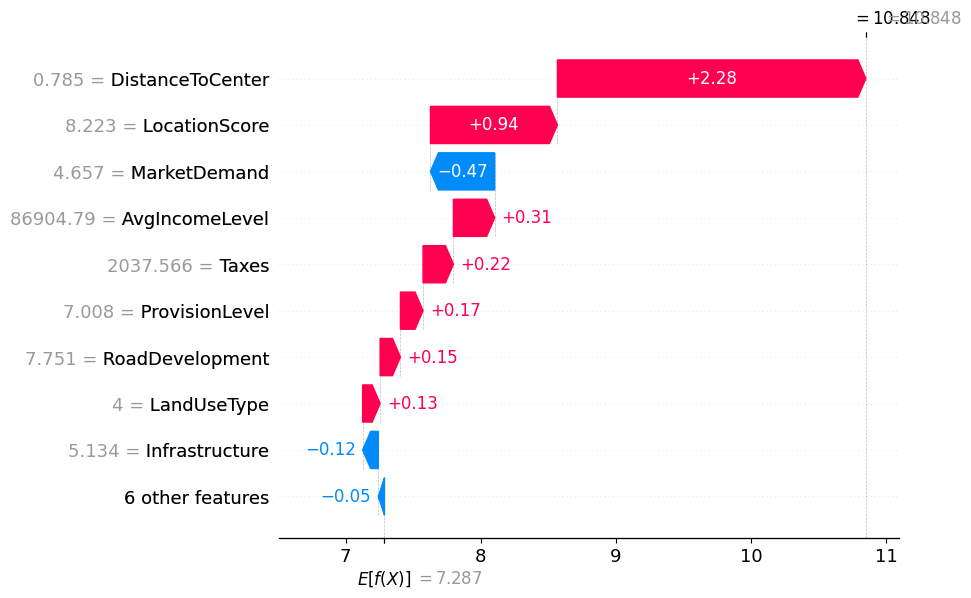


Вклад признаков в прогноз для новой территории:
LandUseType: 0.129
LocationScore: 0.939
AreaTotal: -0.050
AreaResidential: 0.000
AreaCommercial: -0.001
Infrastructure: -0.116
RoadDevelopment: 0.151
EcoRestrictions: 0.039
PopulationDensity: -0.001
AvgIncomeLevel: 0.305
DistanceToCenter: 2.281
MarketDemand: -0.475
Taxes: 0.225
Income: -0.033
ProvisionLevel: 0.167


In [7]:

# 2. Создание геодатафрейма с 10 не пересекающимися полигонами

# Координаты для не пересекающихся полигонов (пример в 2D-пространстве)
coordinates = [
    [(0, 0), (2, 0), (2, 2), (0, 2)],   # Територия 1
    [(3, 0), (5, 0), (5, 2), (3, 2)],   # Територия 2
    [(6, 0), (8, 0), (8, 2), (6, 2)],   # Територия 3
    [(0, 3), (2, 3), (2, 5), (0, 5)],   # Територия 4
    [(3, 3), (5, 3), (5, 5), (3, 5)],   # Територия 5
    [(6, 3), (8, 3), (8, 5), (6, 5)],   # Територия 6
    [(0, 6), (2, 6), (2, 8), (0, 8)],   # Територия 7
    [(3, 6), (5, 6), (5, 8), (3, 8)],   # Територия 8
    [(6, 6), (8, 6), (8, 8), (6, 8)],   # Територия 9
    [(4, 9), (6, 9), (6, 11), (4, 11)]  # Територия 10
]

# Создание геометрий (полигоны)
polygons = [Polygon(coords) for coords in coordinates]

# Создание геодатафрейма
gdf = gpd.GeoDataFrame({
    'geometry': polygons,
    'LandUseType': np.random.choice(['residential', 'mixed_use', 'industrial'], 10),
    'LocationScore': np.random.uniform(1, 10, 10),
    'AreaTotal': np.random.uniform(100, 20000, 10),
    'AreaResidential': np.random.uniform(0, 15000, 10),
    'AreaCommercial': np.random.uniform(0, 10000, 10),
    'Infrastructure': np.random.uniform(1, 10, 10),
    'RoadDevelopment': np.random.uniform(1, 10, 10),
    'EcoRestrictions': np.random.uniform(0, 5, 10),
    'PopulationDensity': np.random.uniform(50, 5000, 10),
    'AvgIncomeLevel': np.random.uniform(20000, 100000, 10),
    'DistanceToCenter': np.random.uniform(0.5, 20, 10),
    'MarketDemand': np.random.uniform(1, 10, 10),
    'Taxes': np.random.uniform(1000, 5000, 10),
    'Income': np.random.uniform(5000, 20000, 10),
    'ProvisionLevel': np.random.uniform(1, 10, 10)
})

# Кодирование LandUseType для модели (нужно для предсказания)
gdf['LandUseType'] = le.transform(gdf['LandUseType'])  # Используем числовые метки напрямую

# 3. Предсказание доходности для геодатафрейма
X_new = gdf.drop('geometry', axis=1)  # Убираем только геометрию, сохраняем LandUseType как числовой
investment_returns = model.predict(X_new)
gdf['InvestmentReturn'] = investment_returns

# Декодируем LandUseType обратно для визуализации
gdf['LandUseType'] = le.inverse_transform(gdf['LandUseType'])

# 4. Визуализация карты территорий с типом землепользования
fig, ax = plt.subplots(figsize=(12, 12))
# Отрисовываем полигоны с цветом по доходности
gdf.plot(column='InvestmentReturn', ax=ax, cmap='RdYlGn', legend=True, 
         edgecolor='black', alpha=0.7, legend_kwds={'label': "Доходность (%)"})
plt.title("Карта территорий с предсказанной доходностью и типом землепользования")

# Добавляем аннотации с доходностью и типом землепользования
for idx, row in gdf.iterrows():
    centroid = row['geometry'].centroid
    plt.annotate(f"{row['InvestmentReturn']:.2f}%\n{row['LandUseType']}", 
                 xy=centroid.coords[0], 
                 ha='center', va='center', fontsize=8, 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

plt.axis('off')
plt.show()

# 5. Создание explainer для SHAP
explainer = shap.TreeExplainer(model)

# Визуализация влияния признаков для одной территории (например, первой)
new_territory = X_new.iloc[[0]]  # Берем первую территорию
shap_values_new = explainer.shap_values(new_territory.values)

# Bar Plot для первой территории
plt.figure(figsize=(12, 6))
plt.bar(new_territory.columns, shap_values_new[0], 
        color=['green' if x > 0 else 'red' for x in shap_values_new[0]])
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Признаки")
plt.ylabel("Вклад в доходность (%)")
plt.title(f"Влияние признаков на доходность для территории 0 ({gdf['LandUseType'].iloc[0]})")
plt.tight_layout()
plt.show()

shap.waterfall_plot(shap.Explanation(values=shap_values_new[0], 
                                     base_values=explainer.expected_value, 
                                     data=new_territory.iloc[0], 
                                     feature_names=new_territory.columns.tolist()))
# Числовой вклад признаков для новой территории
print("\nВклад признаков в прогноз для новой территории:")
for feature, shap_val in zip(new_territory.columns, shap_values_new[0]):
    print(f"{feature}: {shap_val:.3f}")

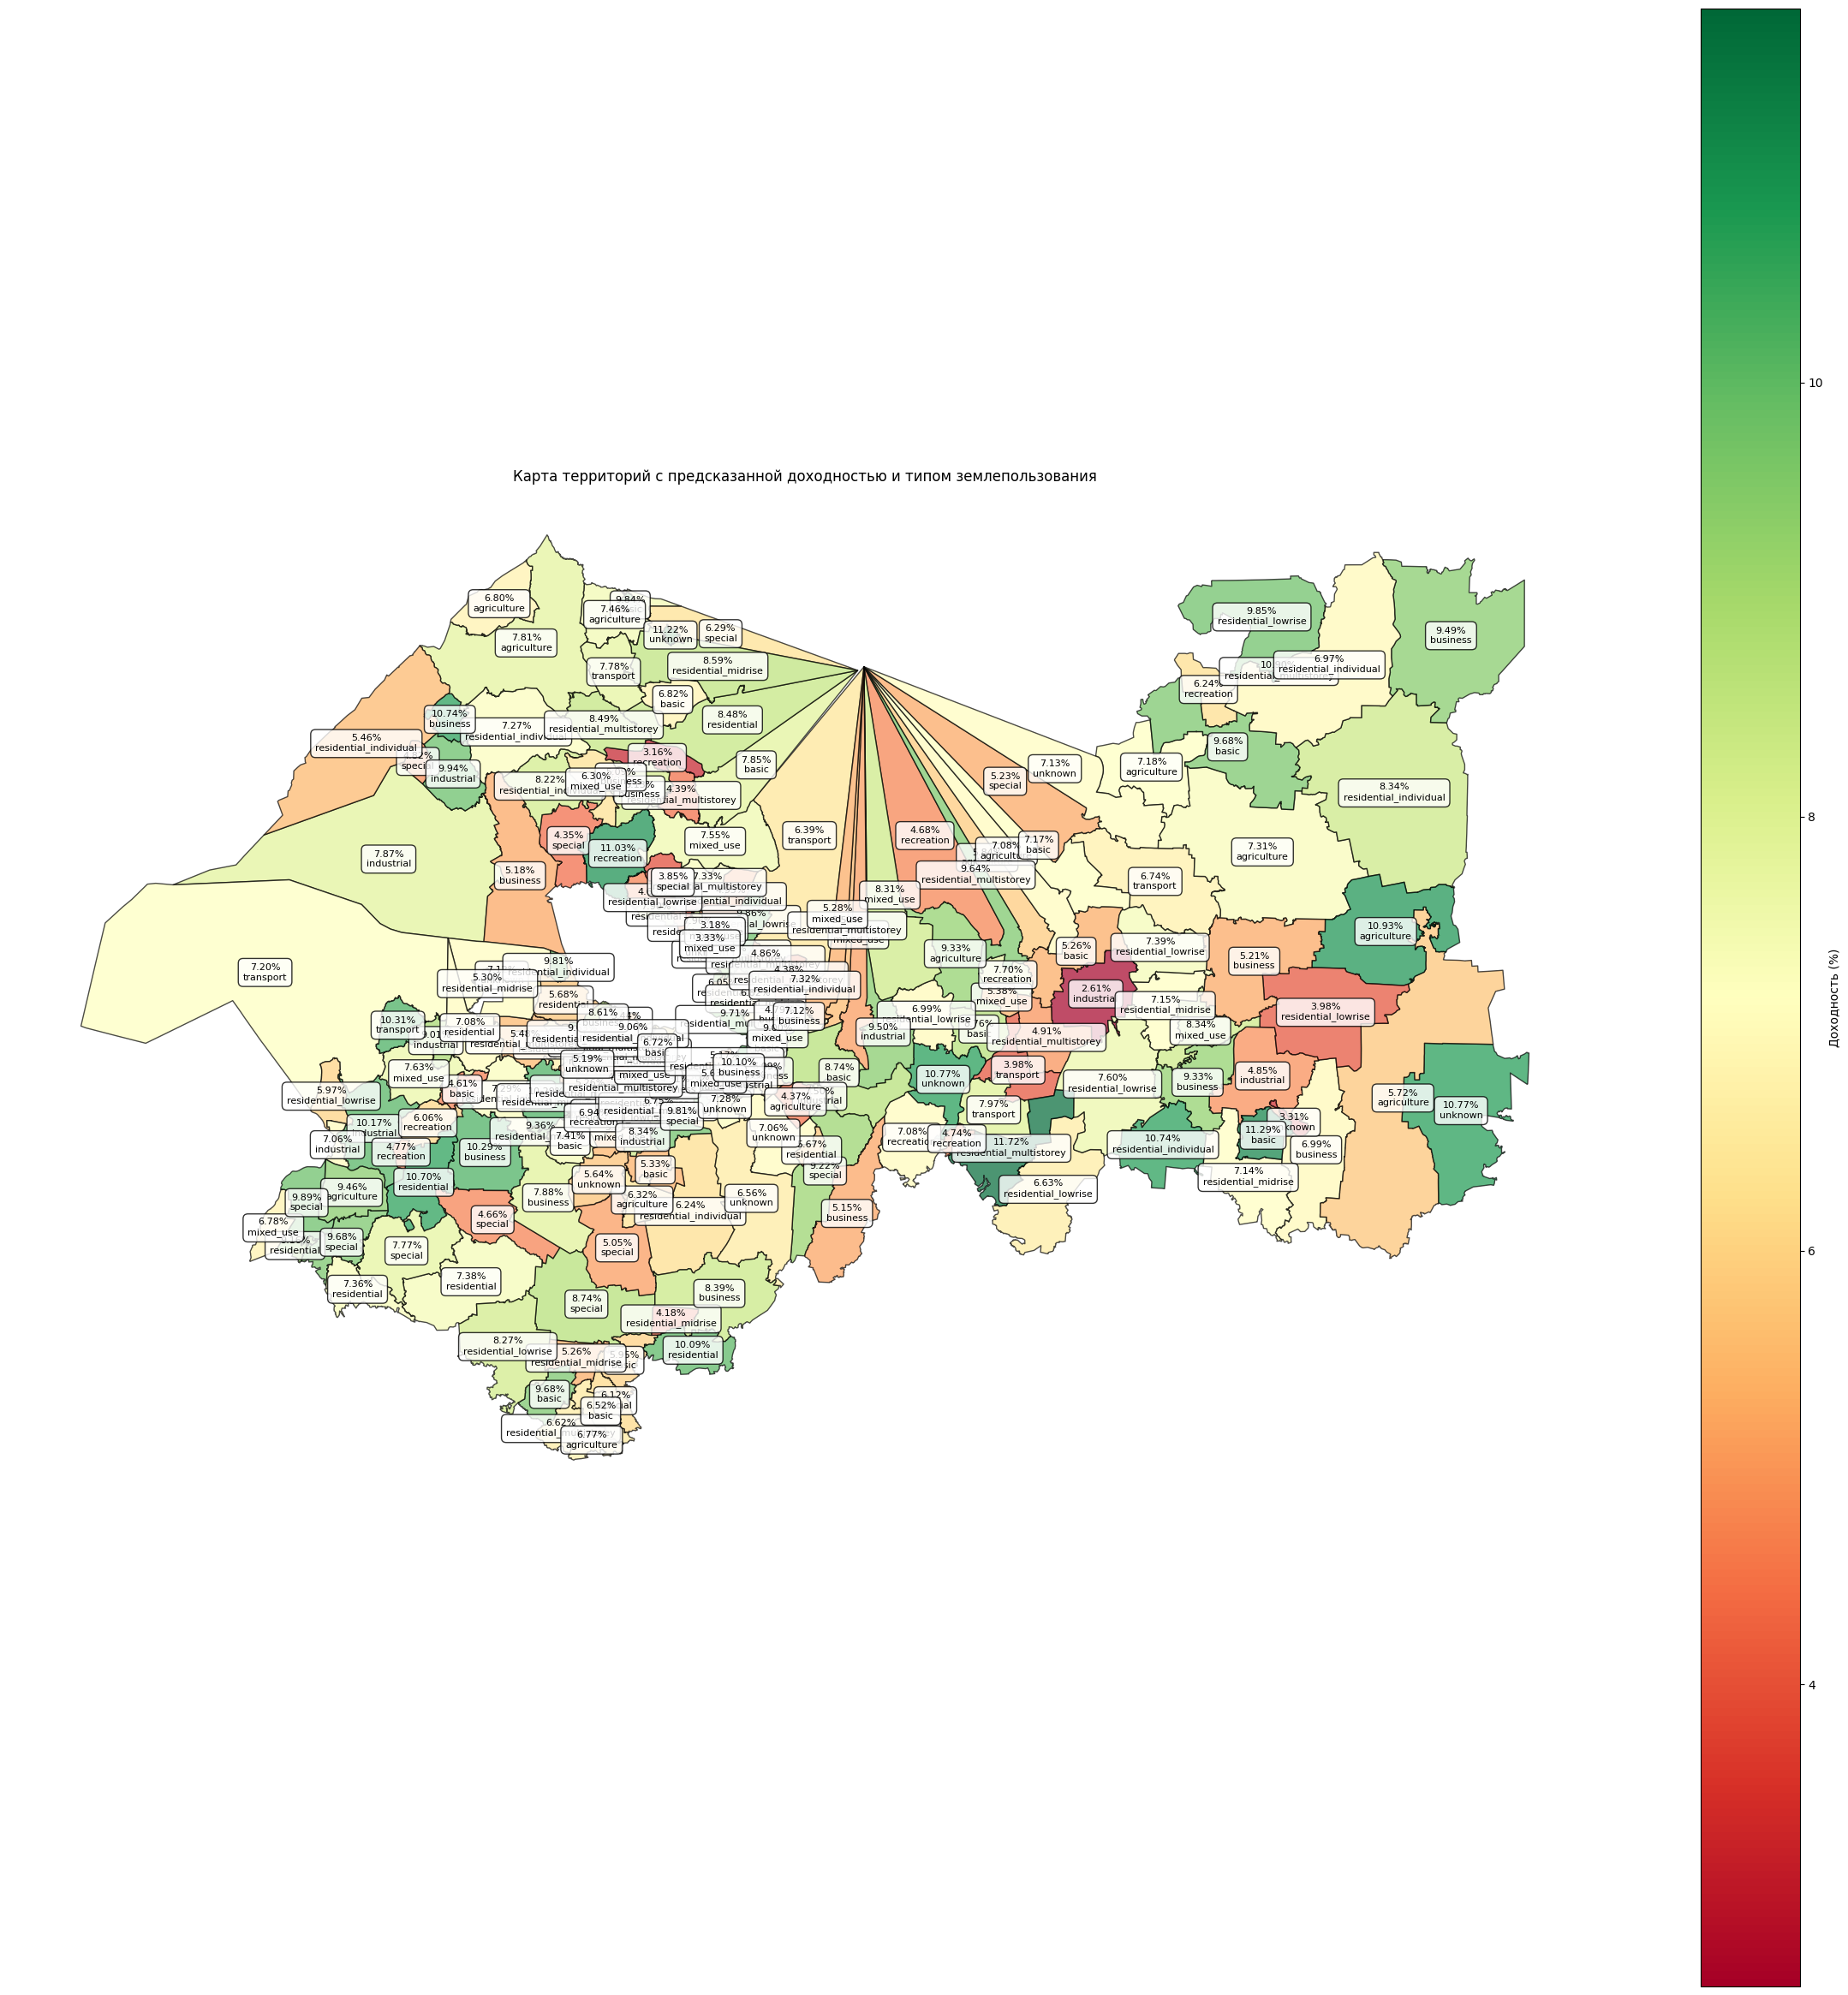

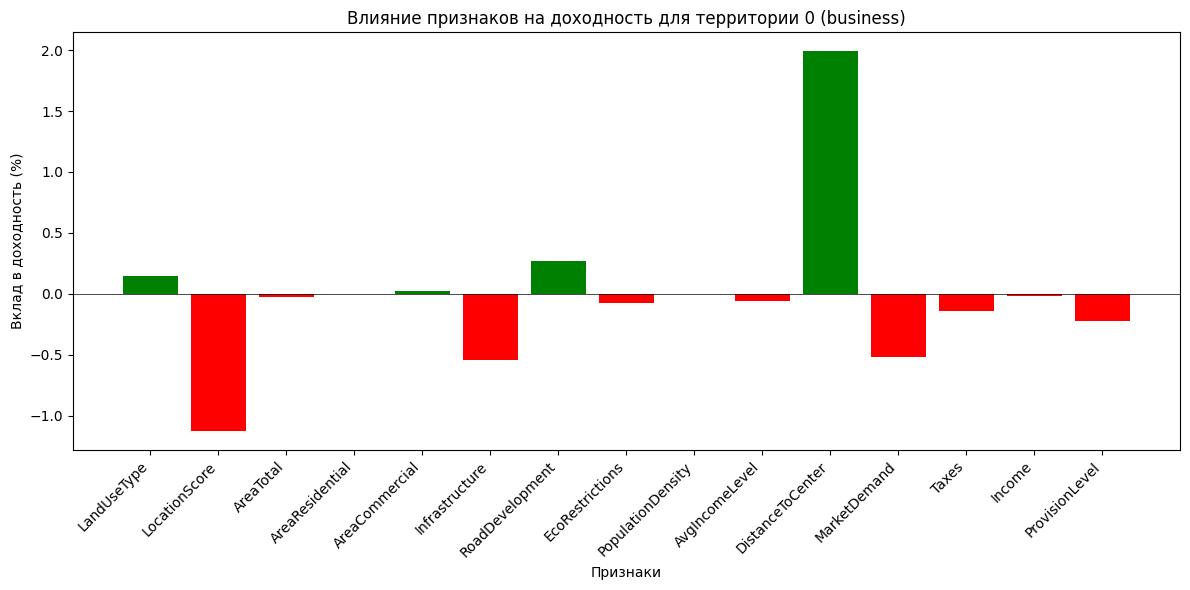

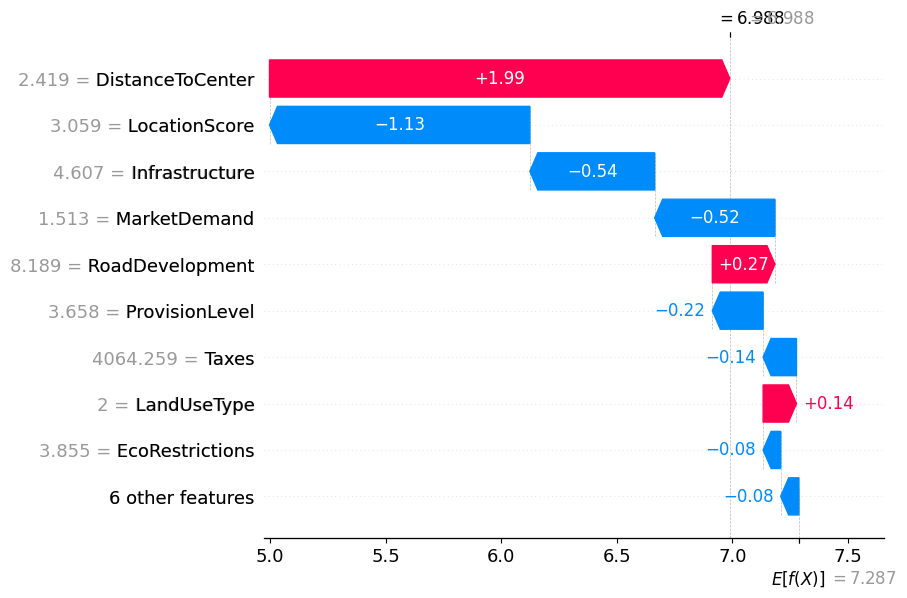


Вклад признаков в прогноз для новой территории:
LandUseType: 0.144
LocationScore: -1.126
AreaTotal: -0.023
AreaResidential: 0.000
AreaCommercial: 0.021
Infrastructure: -0.540
RoadDevelopment: 0.271
EcoRestrictions: -0.076
PopulationDensity: 0.002
AvgIncomeLevel: -0.058
DistanceToCenter: 1.990
MarketDemand: -0.520
Taxes: -0.144
Income: -0.020
ProvisionLevel: -0.220


In [8]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import shap
from shapely.geometry import Polygon

# Подготовка имеющегося GeoDataFrame
territory_gdf = territory_gdf.copy()  # Копируем, чтобы избежать изменений в оригинале

# Добавляем необходимые атрибуты для модели (случайные данные для примера)
np.random.seed(42)  # Фиксируем генератор случайных чисел для воспроизводимости

territory_gdf['LandUseType'] = np.random.choice(['residential', 'recreation', 'special', 'industrial', 
        'agriculture', 'transport', 'business', 'basic', 
        'residential_individual', 'residential_lowrise', 
        'residential_midrise', 'residential_multistorey', 'unknown', 
        'mixed_use'], len(territory_gdf))
territory_gdf['LocationScore'] = np.random.uniform(1, 10, len(territory_gdf))
territory_gdf['AreaTotal'] = np.random.uniform(100, 20000, len(territory_gdf))
territory_gdf['AreaResidential'] = np.random.uniform(0, 15000, len(territory_gdf))
territory_gdf['AreaCommercial'] = np.random.uniform(0, 10000, len(territory_gdf))
territory_gdf['Infrastructure'] = np.random.uniform(1, 10, len(territory_gdf))
territory_gdf['RoadDevelopment'] = np.random.uniform(1, 10, len(territory_gdf))
territory_gdf['EcoRestrictions'] = np.random.uniform(0, 5, len(territory_gdf))
territory_gdf['PopulationDensity'] = np.random.uniform(50, 5000, len(territory_gdf))
territory_gdf['AvgIncomeLevel'] = np.random.uniform(20000, 100000, len(territory_gdf))
territory_gdf['DistanceToCenter'] = np.random.uniform(0.5, 20, len(territory_gdf))
territory_gdf['MarketDemand'] = np.random.uniform(1, 10, len(territory_gdf))
territory_gdf['Taxes'] = np.random.uniform(1000, 5000, len(territory_gdf))
territory_gdf['Income'] = np.random.uniform(5000, 20000, len(territory_gdf))
territory_gdf['ProvisionLevel'] = np.random.uniform(1, 10, len(territory_gdf))

# Кодирование LandUseType для модели
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
territory_gdf['LandUseType'] = le.fit_transform(territory_gdf['LandUseType'])

# Подготовка данных для предсказания
X_new = territory_gdf.drop(columns=['geometry', 'territory_id'])  # Убираем ненужный столбец
investment_returns = model.predict(X_new)

# Добавляем предсказания в GeoDataFrame
territory_gdf['InvestmentReturn'] = investment_returns


# Добавляем предсказания в GeoDataFrame
territory_gdf['InvestmentReturn'] = investment_returns

# Декодируем LandUseType обратно для визуализации
territory_gdf['LandUseType'] = le.inverse_transform(territory_gdf['LandUseType'])

# 🔹 Визуализация предсказаний на карте
fig, ax = plt.subplots(figsize=(30, 30))
territory_gdf.plot(column='InvestmentReturn', ax=ax, cmap='RdYlGn', legend=True, 
                    edgecolor='black', alpha=0.7, legend_kwds={'label': "Доходность (%)"})

plt.title("Карта территорий с предсказанной доходностью и типом землепользования")

# Аннотации
for idx, row in territory_gdf.iterrows():
    centroid = row['geometry'].centroid
    plt.annotate(f"{row['InvestmentReturn']:.2f}%\n{row['LandUseType']}", 
                 xy=centroid.coords[0], 
                 ha='center', va='center', fontsize=8, 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

plt.axis('off')
plt.show()

# 🔹 SHAP-анализ для объяснения модели
explainer = shap.TreeExplainer(model)

# Анализ SHAP для первой территории
new_territory = X_new.iloc[[0]]  
shap_values_new = explainer.shap_values(new_territory.values)

# Бар-график SHAP
plt.figure(figsize=(12, 6))
plt.bar(new_territory.columns, shap_values_new[0], 
        color=['green' if x > 0 else 'red' for x in shap_values_new[0]])
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Признаки")
plt.ylabel("Вклад в доходность (%)")
plt.title(f"Влияние признаков на доходность для территории 0 ({territory_gdf['LandUseType'].iloc[0]})")
plt.tight_layout()
plt.show()

shap.waterfall_plot(shap.Explanation(values=shap_values_new[0], 
                                     base_values=explainer.expected_value, 
                                     data=new_territory.iloc[0], 
                                     feature_names=new_territory.columns.tolist()))

# Вывод SHAP-вкладов
print("\nВклад признаков в прогноз для новой территории:")
for feature, shap_val in zip(new_territory.columns, shap_values_new[0]):
    print(f"{feature}: {shap_val:.3f}")


In [9]:
territory_gdf

,territory_id,geometry,LandUseType,LocationScore,AreaTotal,AreaResidential,AreaCommercial,Infrastructure,RoadDevelopment,EcoRestrictions,PopulationDensity,AvgIncomeLevel,DistanceToCenter,MarketDemand,Taxes,Income,ProvisionLevel,InvestmentReturn
0,3,"POLYGON ((580049.515 6617067.72, 580225.344 66...",business,3.059183,4394.838447,681.695705,9823.786169,4.606868,8.189049,3.854609,2602.200341,57216.448983,2.418715,1.513492,4064.259106,9594.702482,3.657614,6.988400
1,4,"POLYGON ((573514.444 6620389.851, 573579.919 6...",industrial,1.692819,12495.520469,4214.447844,1120.389022,6.036763,9.981407,4.223916,2469.790572,24811.387408,13.375903,3.539684,4153.789373,16834.777399,3.091459,4.845524
2,5,"POLYGON ((564707.328 6594903.594, 564341.814 6...",unknown,3.607763,1798.414553,14256.172261,3978.555990,2.397162,4.156406,3.805120,3350.978075,64983.745270,15.405267,3.355351,3659.939614,11696.292746,3.529040,3.307088
3,6,"POLYGON ((560629.509 6557332.762, 560642.857 6...",residential_midrise,2.450992,1128.466251,13353.956758,9694.704333,2.637353,7.904695,3.131102,741.273711,96610.022760,5.668405,3.222809,2041.147430,16975.705108,8.231345,7.141314
4,7,"POLYGON ((560659.317 6585430.874, 559919.213 6...",basic,9.367279,10673.957168,6834.851292,8655.071259,8.756071,4.617378,0.656224,198.369270,34024.235389,0.908427,9.156291,4628.780123,17336.335605,9.363052,11.291259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,204,"POLYGON ((363803.737 6614904.469, 363821.597 6...",business,8.403405,13945.398911,2600.603929,657.086394,8.830890,5.258889,0.024700,3363.960428,47976.258380,3.139405,1.298704,4382.417452,16917.733167,6.723592,10.099149
185,205,"POLYGON ((392924.072 6551507.217, 393174.409 6...",business,4.241716,9145.367189,13451.481369,7755.276167,1.191425,9.713741,4.759059,4970.989838,81972.282494,15.151814,3.735518,3769.971307,15606.297159,4.493491,5.152641
186,206,"POLYGON ((363959.223 6596385.107, 364013.066 6...",unknown,2.143545,12588.405794,1203.506185,4532.888347,8.872315,2.669730,3.195600,3326.103990,72909.648886,13.310626,6.878465,2719.724310,5753.390172,7.067173,6.561759
187,1267,"POLYGON ((283435.008 6647206.979, 283361.394 6...",residential_midrise,5.700189,11727.854807,7867.670844,5243.902693,5.760434,8.817609,4.339591,2811.027916,34815.645429,19.153985,9.444743,3691.866490,6093.527531,3.339145,5.300537
